<a href="https://colab.research.google.com/github/JuliaOlif/Mind-Reading-/blob/main/MindReading_Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Function to install nilearn - Please run this first
!pip install nilearn

# Week 3: Voxel-Based Morphometry

In this tutorial, we will explore voxel-based morphometry (VBM) using Python libraries such as Nilearn and Nibabel. VBM is a neuroimaging analysis technique that allows us to investigate focal differences in brain anatomy, particularly in gray matter density.

**Learning objectives**  
- Understand the principles of transformation for inter-subject alignment
- Learn how to preprocess MRI data for VBM analysis
- Perform VBM analysis using Python libraries

**Estimated time to complete:** 1 hour


In [15]:
import os
import urllib.request

def download_file(url, outfile):
    """Download file from URL if not already present."""
    if not os.path.exists(outfile):
        print(f"Downloading {outfile}...")
        urllib.request.urlretrieve(url, outfile)
        print(f"Saved as {outfile}")
    else:
        print(f"{outfile} already exists, skipping download.")

# Downloading some required data
download_file(
    "https://www.dropbox.com/scl/fi/h1pjjm093wyw8luxig79s/sub-0001_run-1_T1w.nii.gz?rlkey=3m5ymyhc84teumfy3zthc4n9m&dl=1",
    "anat.nii.gz"
)

download_file(
    "https://www.dropbox.com/scl/fi/vgvpys15d8dhlg3oiulxy/sub-0001_run-1_T1w_brain.nii.gz?rlkey=gppi5n6jzhgsotfu0tqhtkdsy&dl=1",
    "anat_brain.nii.gz"
)

download_file(
    "https://www.dropbox.com/scl/fi/4t5i3jdvd026ji64vd8kg/sub-0001_run-1_T1w_brain_flirt.nii.gz?rlkey=y76f3azxmmbse5ggmifs0bdg7&dl=1",
    "anat_brain_flirt.nii.gz"
)

download_file(
    "https://www.dropbox.com/scl/fi/c5rep4ty74i9w38gpnis2/sub-0001_run-1_T1w_brain_fnirt.nii.gz?rlkey=wz7cfgni69sak6cdsao95zsbm&dl=1",
    "anat_brain_fnirt.nii.gz"
)

anat.nii.gz already exists, skipping download.
anat_brain.nii.gz already exists, skipping download.
anat_brain_flirt.nii.gz already exists, skipping download.
anat_brain_fnirt.nii.gz already exists, skipping download.


### Recap: Anatomical Data
Over the last two weeks, we worked with anatomical MRI data. We learned how to load and visualize these data using the `nilearn` library. Anatomical MRI data provide high-resolution images of brain structure, which are essential for various neuroimaging analyses. So far, we worked with the raw anatomical data. As you may recall, the brains of different people vary in size and shape. We can identify specific regions anatomically, but these regions may not align perfectly across individuals. To compare brain structures across subjects, we need to align their brains to a common reference space. This process is known as spatial normalization or registration.

![Illustration of Normalization](https://drive.google.com/uc?export=view&id=18Am_Ri4ynmgG7XYEuDtVoMmqHfWEmNeG)

### Linear Transformations
The first step that we can take to align the images is to move them in a similar position, orientation, and scale. The raw images that we looked at so far are mostly determined by the position of the participant in the scanner. If a participant's head is tilted or shifted, the resulting image will reflect that. To correct for these differences, we can apply linear transformations to the images:

- **Translation** → shifts along the X, Y, and Z axes (left/right, up/down, front/back)  
- **Rotation** → rotations around the three axes (pitch, roll, yaw)  
- **Scaling** → resizing along the three axes  

![pitchrollyaw](https://www.researchgate.net/profile/Tsang_Ing_Ren/publication/279291928/figure/fig1/AS:292533185462272@1446756754388/Orientation-of-the-head-in-terms-of-pitch-roll-and-yaw-movements-describing-the-three.png)  

*Image from [Arcoverde Neto et al., 2014](https://www.researchgate.net/figure/Orientation-of-the-head-in-terms-of-pitch-roll-and-yaw-movements-describing-the-three_fig1_279291928)*


#### How do we know which transformations to apply?  

First, we need to define a **reference image** (also called the fixed image) to which we want to align all other images (the moving images). We could either use one of the participant's anatomical images as the reference or use a standard brain template (e.g., MNI space). Then, we need to determine the right combination of translations and rotations to align the moving image to the reference image. Of course, we cannot manually inspect every anatomical image and “guess” the right combination of translations and rotations to align them.  
Instead, motion correction relies on an **optimization algorithm**:  

- The algorithm starts with an initial guess of the affine transformation.  
- It then **iteratively adjusts the six parameters** (three translations + three rotations).  
- After each adjustment, it computes how well the moving image matches the reference image using a **cost function** (e.g. the sum of squared differences).  
- The process continues until the cost function is minimized, meaning the two images are as well aligned as possible.  

---

Try it out below: move the sliders to align both images.
Notice how the **cost function value decreases** as alignment improves.

In [16]:
# Note: You do not need to understand the code below. It is just provided to create the interactive demo.
%matplotlib inline

import os
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import nibabel as nib
from ipywidgets import interact, FloatSlider

def build_translation_affine_2d(trans_x: float, trans_y: float) -> np.ndarray:
    """
    Build a 3x3 2D homogeneous translation matrix that maps
    reference pixel indices (i, j) -> source indices (i + trans_y, j + trans_x).

    Notes
    -----
    - We follow image-indexing convention: i = row (y), j = column (x).
    - The returned matrix A is applied to homogeneous coords [i, j, 1]^T.
    """
    A = np.array([[1.0, 0.0, float(trans_y)],
                  [0.0, 1.0, float(trans_x)],
                  [0.0, 0.0, 1.0]], dtype=float)
    return A


def apply_affine_coords_2d(A: np.ndarray, coords_last: np.ndarray) -> np.ndarray:
    """
    Apply a 3x3 affine to a field of 2D coordinates.

    Parameters
    ----------
    A : (3, 3) ndarray
        2D homogeneous affine matrix.
    coords_last : (H, W, 2) ndarray
        Coordinate grid in (i, j) order.

    Returns
    -------
    transformed : (H, W, 2) ndarray
        Transformed coordinates in (i, j) order.
    """
    H, W, _ = coords_last.shape
    ones = np.ones((H, W, 1), dtype=float)
    homo = np.concatenate([coords_last.astype(float), ones], axis=-1)            # (H, W, 3)
    flat = homo.reshape(-1, 3).T                                                # (3, H*W)
    out = (A @ flat).T[:, :2]                                                   # (H*W, 2)
    return out.reshape(H, W, 2)                                                 # (H, W, 2)


def warp_image_2d(image: np.ndarray, A: np.ndarray, order: int = 1,
                  cval: float = 0.0) -> np.ndarray:
    """
    Resample `image` at coordinates given by applying affine A to the
    target grid (backward mapping), using map_coordinates.

    Parameters
    ----------
    image : (H, W) ndarray
        Source (moving) image to be sampled.
    A : (3, 3) ndarray
        Affine mapping target grid -> source coords.
    order : int
        Spline interpolation order for map_coordinates (0=nearest, 1=linear, ...).
    cval : float
        Constant value used for points outside boundaries.

    Returns
    -------
    warped : (H, W) ndarray
        Resampled image.
    """
    H, W = image.shape
    i_coords, j_coords = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    grid_ij = np.stack([i_coords, j_coords], axis=-1)                           # (H, W, 2)
    src_ij = apply_affine_coords_2d(A, grid_ij)                                 # (H, W, 2)
    # map_coordinates expects coords in separate arrays with shape (ndim, H, W)
    coords_for_map = np.stack([src_ij[..., 0], src_ij[..., 1]], axis=0)
    return map_coordinates(image, coords_for_map, order=order, mode="constant", cval=cval)

def apply_initial_translation(mri_slice: np.ndarray, trans_x: float, trans_y: float) -> np.ndarray:
    """Apply an initial (known) translation to create a 'moving' image."""
    A = build_translation_affine_2d(trans_x=trans_x, trans_y=trans_y)
    return warp_image_2d(mri_slice, A, order=1, cval=0.0)


def plot_affine_cost(mri_slice1: np.ndarray, mri_slice2: np.ndarray, trans_x: float = 0, trans_y: float = 0):
    """
    Interactive demo to illustrate a cost function (SSE) for 2D registration.
    - mri_slice1: moving image (will be transformed)
    - mri_slice2: reference image
    - trans_x/trans_y: user-controlled translation (columns/rows)
    """
    if mri_slice1.shape != mri_slice2.shape:
        raise ValueError("The two MRI slices must have the same dimensions.")

    # Build translation that maps target grid -> moving coords
    A = build_translation_affine_2d(trans_x=trans_x, trans_y=trans_y)
    transformed_slice = warp_image_2d(mri_slice1, A, order=1, cval=0.0)

    f, a = plt.subplots(ncols=3, figsize=(15, 5))
    a[0].imshow(transformed_slice, cmap='gray')
    a[0].set_xlabel('x', fontsize=16)
    a[0].set_ylabel('y', fontsize=16)
    a[0].set_title('Moving Image (transformed)', fontsize=18)

    a[1].imshow(mri_slice2, cmap='gray')
    a[1].set_xlabel('x', fontsize=16)
    a[1].set_ylabel('y', fontsize=16)
    a[1].set_title('Reference Image', fontsize=18)

    sse = float(np.sum((transformed_slice - mri_slice2) ** 2))
    a[2].bar(0, sse)
    a[2].set_ylim([0, max(1.0, sse * 1.1)])
    a[2].set_ylabel('SSE', fontsize=18)
    a[2].set_xlabel('Cost Function', fontsize=18)
    a[2].set_xticks([])
    a[2].set_title(f'Parameters: (tx={int(trans_x)}, ty={int(trans_y)})', fontsize=16)
    plt.tight_layout()
    plt.show()

# Load an example NIfTI and extract a 2D slice
img = nib.load(os.path.abspath('anat.nii.gz'))
mri_slice = img.get_fdata()[40, ...]
mri_slice1 = np.flipud(mri_slice.T)   # moving image
mri_slice2 = np.flipud(mri_slice.T)   # reference image

# Create an initially misaligned moving image by applying a random translation
rng = np.random.default_rng()
initial_trans_x = int(rng.integers(-5, 6))
initial_trans_y = int(rng.integers(-5, 6))
mri_slice1_translated = apply_initial_translation(mri_slice1, initial_trans_x, initial_trans_y)

def interactive_plot(trans_x, trans_y):
    plot_affine_cost(mri_slice1_translated, mri_slice2, trans_x, trans_y)

interact(
    interactive_plot,
    trans_x=FloatSlider(value=0, min=-30, max=30, step=1, description="tx (cols)"),
    trans_y=FloatSlider(value=0, min=-30, max=30, step=1, description="ty (rows)")
)

interactive(children=(FloatSlider(value=0.0, description='tx (cols)', max=30.0, min=-30.0, step=1.0), FloatSli…

<function __main__.interactive_plot(trans_x, trans_y)>

### Non-linear Transformations
While linear transformations can correct for global differences in position, orientation, and scale, they cannot account for local anatomical variations between individuals. For example, the shape and size of specific brain regions can vary significantly across people. To address these local differences, we need to apply **non-linear transformations**. Non-linear transformations allow for more complex deformations of the brain images, enabling us to better align corresponding anatomical structures across subjects. These transformations can stretch, compress, or warp specific regions of the brain to achieve better alignment.

Below, we show the effect of linear and non-linear transformation using the example participant. The first image shows the original anatomical scan, the second image shows the result after applying a linear transformation, and the third image shows the result after applying a non-linear transformation. In this case, the brain was aligned to the MNI152 template, a standard brain template commonly used in neuroimaging studies.

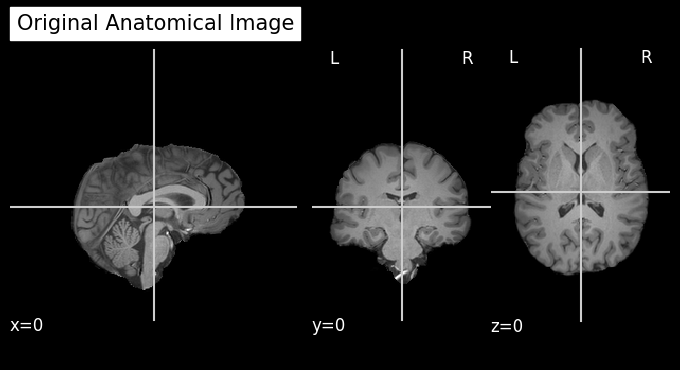

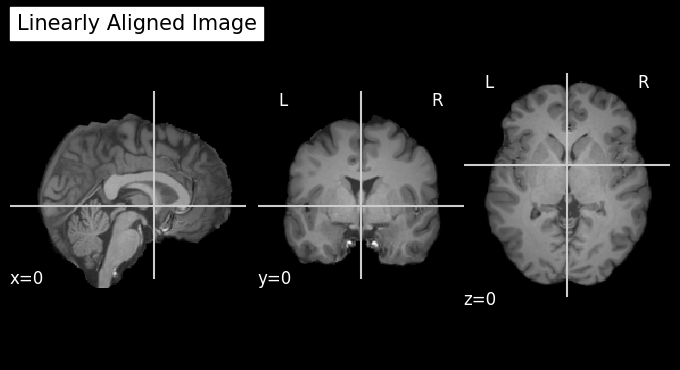

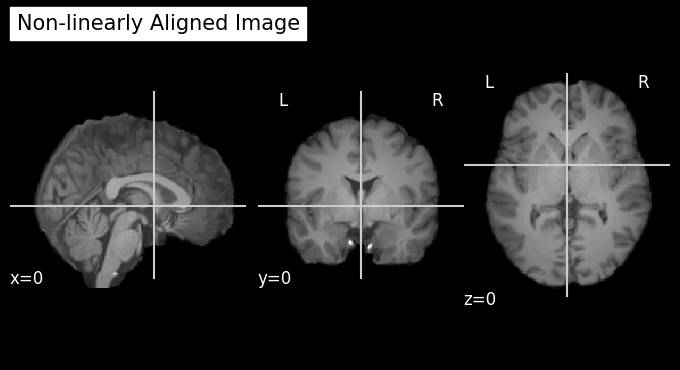

In [17]:
from nilearn import plotting
from nilearn import image

anat = image.load_img(os.path.abspath('anat_brain.nii.gz'))
anat_flirt = image.load_img(os.path.abspath('anat_brain_flirt.nii.gz'))
anat_fnirt = image.load_img(os.path.abspath('anat_brain_fnirt.nii.gz'))

plotting.plot_anat(anat, title='Original Anatomical Image', display_mode='ortho', cut_coords=(0, 0, 0), colorbar=False, vmax=3000)
plotting.plot_anat(anat_flirt, title='Linearly Aligned Image', display_mode='ortho', cut_coords=(0, 0, 0), colorbar=False, vmax=3000)
plotting.plot_anat(anat_fnirt, title='Non-linearly Aligned Image', display_mode='ortho', cut_coords=(0, 0, 0), colorbar=False, vmax=3000)

Even after careful preprocessing, small **misalignments** often remain between participants’ brain images.  
To reduce their impact, we usually apply **spatial smoothing**.  

Spatial smoothing works by averaging the signal across **neighbouring voxels**, which helps:  
- increase the signal-to-noise ratio
- make data more comparable across participants

In practice, smoothing is performed with a **Gaussian kernel**:  
- The kernel’s size is described by its **full width at half maximum (FWHM)** — the width of the Gaussian curve at half of its peak value.  
- FWHM is specified in **millimetres**, determining how much neighbouring signal is blended.  

---

In the demo below, you’ll see how applying spatial smoothing changes the appearance of the data.  

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import image
import ipywidgets as widgets

# Load the functional image (BOLD reference)
anat_filename = os.path.abspath('anat.nii.gz')
anat_img = image.load_img(anat_filename)  # niimg

# Helper: extract a mid axial slice for display
def mid_axial_slice(np3d):
    x, y, z = np3d.shape
    sl = z // 2
    return np.flipud(np3d[:, :, sl].T)

# Update + plot based on FWHM (in mm)
def update_plot(fwhm):
    # Apply Gaussian smoothing with specified FWHM (mm).
    # If fwhm == 0, just show the original.
    anat_smoothed = image.smooth_img(anat_img, fwhm=fwhm) if fwhm > 0 else anat_img

    # Fetch data for plotting
    orig_slice = mid_axial_slice(anat_img.get_fdata())
    smooth_slice = mid_axial_slice(anat_smoothed.get_fdata())
    # Plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_slice, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(smooth_slice, cmap='gray')
    plt.title(f'Smoothed Image (FWHM = {fwhm:.1f} mm)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Interactive slider for FWHM (mm)
sigma_slider = widgets.FloatSlider(
    value=2.0, min=0.0, max=10.0, step=0.1,
    description='FWHM (mm):', continuous_update=True
)

widgets.interactive(update_plot, fwhm=sigma_slider)

interactive(children=(FloatSlider(value=2.0, description='FWHM (mm):', max=10.0), Output()), _dom_classes=('wi…

### Voxel-Based Morphometry (VBM)
Now that we understand how to align anatomical images across subjects using linear and non-linear transformations, and remove noise through spatial smoothing, we can proceed with voxel-based morphometry (VBM) analysis. In addition to these preprocessin steps, VBM typically also involves **segmentation** of the anatomical images into different tissue types. We covered segmentation last week. As a brief reminder, segmentation is the process of classifying different tissue types in the brain, such as gray matter, white matter, and cerebrospinal fluid (CSF), based on differences in voxel intensity (histogram) and spatial information. This step is crucial for VBM because it allows us to focus our analysis on specific tissue types, such as gray matter, which is often of interest in studies of brain structure and function.

Let's have a look at the input data for a VBM analysis: the segmented gray matter image aligned to a common template and smoothed with a Gaussian kernel for all participants in a study.


In [19]:
# Loading example VBM dataset
from nilearn.datasets import fetch_oasis_vbm

oasis_dataset = fetch_oasis_vbm(n_subjects=10) # We only load 10 participants for this demo
gray_matter_map_filenames = oasis_dataset.gray_matter_maps

[fetch_oasis_vbm] Dataset found in /root/nilearn_data/oasis1

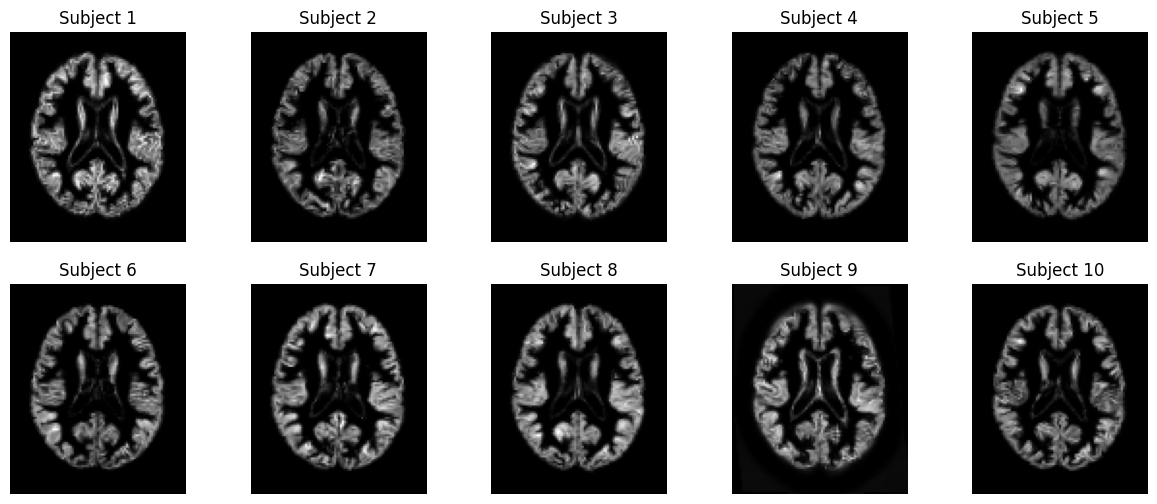

In [20]:
# Plot all gray matter maps in a grid
n_subjects = len(gray_matter_map_filenames)
n_cols = 5
n_rows = int(np.ceil(n_subjects / n_cols))
plt.figure(figsize=(15, 3 * n_rows))
for i, gm_map_file in enumerate(gray_matter_map_filenames):
    gm_img = nib.load(gm_map_file)
    gm_data = gm_img.get_fdata()
    gm_slice = mid_axial_slice(gm_data)

    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(gm_slice, cmap='gray')
    plt.title(f'Subject {i + 1}')
    plt.axis('off')

As you can see from the plot above, the participants are well aligned, i.e. the brains all have the same size and shape. However, there are noticeable differences in the intensity values across participants (some images are lighter or darker), which reflect differences in gray matter density. VBM analysis aims to identify regions of the brain where there are significant differences in gray matter density between groups or conditions. This involves performing statistical analysis on the voxel-wise gray matter density values across participants. In the simplest case, this is done by comparing the value of each voxel across participants using a t-test or correlation. This is then simply repeated for all voxels in the brain, resulting in a statistical map that highlights regions with significant differences. Let's see if we can identify an association between age and gray matter density in this dataset.

**Note**: We will use a small subset of the data (10 participants) for this demo to keep the computations fast. In practice, VBM analyses are typically performed on larger datasets (e.g., 50-100 participants or more) to ensure sufficient statistical power.

**Note**: We will cover the statistical analysis in much more detail in a few weeks when we discuss modelling of task-based fMRI data. For now, we will keep it simple and focus on the preprocessing steps and basic VBM analysis.

Subject 1: Age = 74.0 years
Subject 2: Age = 55.0 years
Subject 3: Age = 73.0 years
Subject 4: Age = 28.0 years
Subject 5: Age = 18.0 years
Subject 6: Age = 24.0 years
Subject 7: Age = 21.0 years
Subject 8: Age = 20.0 years
Subject 9: Age = 74.0 years
Subject 10: Age = 52.0 years


[fetch_icbm152_brain_gm_mask] Dataset found in /root/nilearn_data/icbm152_2009

[SecondLevelModel.fit] Fitting second level model. Take a deep breath.

[SecondLevelModel.fit] Loading mask from <nibabel.nifti1.Nifti1Image object at 0x7c6ba94f67e0>

[SecondLevelModel.fit] Loading data from <nibabel.nifti1.Nifti1Image object at 0x7c6be498b290>

/tmp/ipython-input-278/2411267978.py:35: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  second_level_model.fit(


[SecondLevelModel.fit] Resampling mask

[SecondLevelModel.fit] Finished fit

[SecondLevelModel.fit] 
Computation of second level model done in 0.54 seconds.

[SecondLevelModel.compute_contrast] Loading data from <nibabel.nifti1.Nifti1Image object at 0x7c6ba8ea6180>

[SecondLevelModel.compute_contrast] Smoothing images

[SecondLevelModel.compute_contrast] Extracting region signals

[SecondLevelModel.compute_contrast] Cleaning extracted signals

[SecondLevelModel.compute_contrast] Computing image from signals

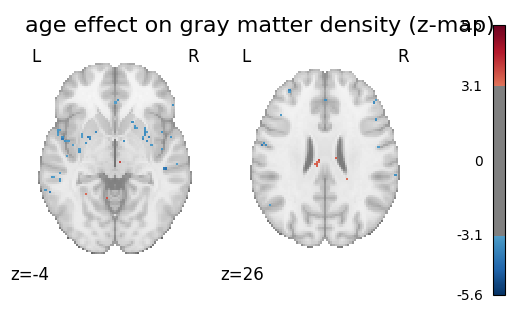

In [21]:
import pandas as pd
from nilearn.glm.second_level import SecondLevelModel
from nilearn.datasets import fetch_icbm152_brain_gm_mask
from nilearn.image import resample_to_img
from nilearn.plotting import plot_stat_map, show

# Get the age information
age = oasis_dataset.ext_vars["age"].astype(float)
for i in range(n_subjects):
    print(f"Subject {i + 1}: Age = {age[i]} years")

# Fetching a grey matter mask and matching it to the data
gm_mask = fetch_icbm152_brain_gm_mask()
mask_img = resample_to_img(
    gm_mask,
    gray_matter_map_filenames[0],
    interpolation="nearest",
)

# Define a statistical model to find association between age and gray matter density
intercept = np.ones(n_subjects)
design_matrix = pd.DataFrame(
    np.vstack((age, intercept)).T,
    columns=["age", "intercept"],
)

# Fit the statistical model to the data
second_level_model = SecondLevelModel(
    smoothing_fwhm=2.0,
    n_jobs=1,
    mask_img=mask_img,
    minimize_memory=False,
    verbose=1,
)
second_level_model.fit(
    gray_matter_map_filenames,
    design_matrix=design_matrix,
)

# Plot the results
z_map = second_level_model.compute_contrast(
    second_level_contrast=[1, 0],
    output_type="z_score",
)

fig = plt.figure(figsize=(5, 3))
display = plot_stat_map(
    z_map,
    threshold=3.1,
    display_mode="z",
    cut_coords=[-4, 26],
    figure=fig,
)
fig.suptitle("age effect on gray matter density (z-map)", fontsize=16)
show()

**Question:** Based on the statistical map above, can you identify any brain regions where gray matter density is significantly associated with age? We only used 10 participants for this analysis and did not correct for multiple comparisons. How could this have affected the results?

## Final Exercise: Investigating Sex Differences in Gray Matter

In this exercise, you will apply what you've learned about VBM to investigate whether there are differences in gray matter density between males and females. This is a well-studied topic in neuroimaging, with some studies reporting regional differences in areas such as the hippocampus, amygdala, and prefrontal cortex.

**Your tasks:**
1. Load a larger subset of the OASIS dataset (50 participants)
2. Examine the sex distribution in the sample
3. Create a design matrix that models sex as the variable of interest
4. Run the VBM analysis and visualize the results
5. Interpret your findings

**Hint:** The sex variable is stored in `oasis_dataset.ext_vars["mf"]` where "M" = male and "F" = female.

### Step 1: Load the data
First, load a larger subset of the OASIS dataset. We'll use 50 participants to have more statistical power than in our earlier example.

In [23]:
# Load a larger subset of the OASIS dataset
# TODO: Modify the n_subjects parameter to load 50 participants instead of 10
# Note: If you run into memory issues, you can try loading fewer participants instead (e.g. 30).
oasis_dataset_large = fetch_oasis_vbm(n_subjects=50)
gray_matter_maps = oasis_dataset_large.gray_matter_maps
print(f"Loaded {len(gray_matter_maps)} participants")

[fetch_oasis_vbm] Dataset found in /root/nilearn_data/oasis1

Loaded 50 participants


### Step 2: Examine the sex distribution
Before running the analysis, it's important to check the distribution of males and females in our sample. An imbalanced sample could affect our results.

In [24]:
# Extract sex information from the dataset
# Hint: Look at oasis_dataset_large.ext_vars - it contains participant information
sex = oasis_dataset_large.ext_vars["mf"]

# TODO: Print the number of males ("M") and females ("F") in the sample
# Hint: You can use np.sum(sex == "M") to count males
print(f"Sex distribution in sample:")
nmales = np.sum(sex == "M")
nfemales = np.sum(sex == "F")
print(f"  Males (M):", nmales)
print(f"  Females (F):", nfemales)

Sex distribution in sample:
  Males (M): 20
  Females (F): 30


### Step 3: Create the design matrix
Now you need to create a design matrix for the VBM analysis.

**Your task**: Create a design matrix with two columns:
- **sex**: coded as 1 for male, 0 for female  
- **intercept**: a column of ones (this is the baseline)

Look back at how we created the design matrix for the age analysis earlier in this notebook. You'll need to adapt that approach for sex instead of age.

In [25]:
# TODO: Create the design matrix for sex differences analysis
#
# Step 1: Convert sex to numeric values (Male=1, Female=0)
# Hint: (sex == "M") gives True/False, use .astype(float) to convert to 1.0/0.0
sex_coded = (sex == "M").astype(float)

# Step 2: Create an intercept column (array of ones)
n_subjects_large = len(gray_matter_maps)
intercept = np.ones(n_subjects_large)

# Step 3: Combine into a pandas DataFrame
# Hint: Look at how design_matrix was created in the age analysis above
design_matrix_sex = pd.DataFrame(
    np.vstack((sex_coded, intercept)).T,
    columns=["sex", "intercept"],
)

# Check your work - this should show a DataFrame with 'sex' and 'intercept' columns
print("Design matrix (first 10 rows):")
print(design_matrix_sex.head(10))

Design matrix (first 10 rows):
   sex  intercept
0  0.0        1.0
1  0.0        1.0
2  0.0        1.0
3  1.0        1.0
4  1.0        1.0
5  0.0        1.0
6  1.0        1.0
7  0.0        1.0
8  1.0        1.0
9  0.0        1.0


### Step 4: Run the VBM analysis
Now fit the second-level model and compute the contrast for sex differences.

**Your task**: Complete the code below by:
1. Passing your `design_matrix_sex` to the model's `fit()` method
2. Setting up the correct contrast to test for sex effects

**Important**: The contrast should test the first column (sex) while ignoring the intercept. Since we have 2 columns [sex, intercept], what should the contrast weights be?

In [26]:
# Fit the second-level model (this part is provided for you)
second_level_model_sex = SecondLevelModel(
    smoothing_fwhm=2.0,
    n_jobs=1,
    mask_img=mask_img,
    minimize_memory=True,
    verbose=1,
)

# TODO: Fit the model with the gray matter maps and your design matrix
second_level_model_sex.fit(
    gray_matter_maps,
    design_matrix= design_matrix_sex,  # <-- Insert your design matrix here
)

# TODO: Compute the contrast for sex differences
# Hint: For the age analysis, we used [1, 0] to test age (first column)
# What contrast should you use here?
z_map_sex = second_level_model_sex.compute_contrast(
    second_level_contrast= [1,0] ,  # <-- What contrast tests the sex effect?
    output_type="z_score",
)

print("Analysis complete!")

[SecondLevelModel.fit] Fitting second level model. Take a deep breath.

[SecondLevelModel.fit] Loading mask from <nibabel.nifti1.Nifti1Image object at 0x7c6ba94f67e0>

[SecondLevelModel.fit] Loading data from <nibabel.nifti1.Nifti1Image object at 0x7c6ba714eea0>

/tmp/ipython-input-278/3017480320.py:11: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  second_level_model_sex.fit(


[SecondLevelModel.fit] Resampling mask

[SecondLevelModel.fit] Finished fit

[SecondLevelModel.fit] 
Computation of second level model done in 1.06 seconds.

[SecondLevelModel.compute_contrast] Loading data from <nibabel.nifti1.Nifti1Image object at 0x7c6ba05f0cb0>

[SecondLevelModel.compute_contrast] Smoothing images

[SecondLevelModel.compute_contrast] Extracting region signals

[SecondLevelModel.compute_contrast] Cleaning extracted signals

[SecondLevelModel.compute_contrast] Computing image from signals

Analysis complete!


### Step 5: Visualize the results
Once your analysis runs successfully, the code below will display the results.

**Interpreting the map**:
- Positive values (red/yellow) = regions where males have more gray matter than females
- Negative values (blue) = regions where females have more gray matter than males

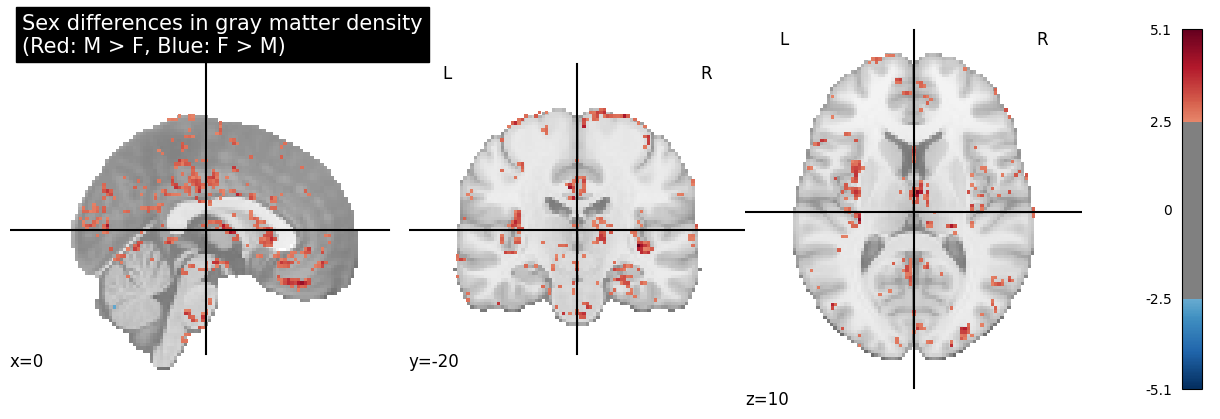

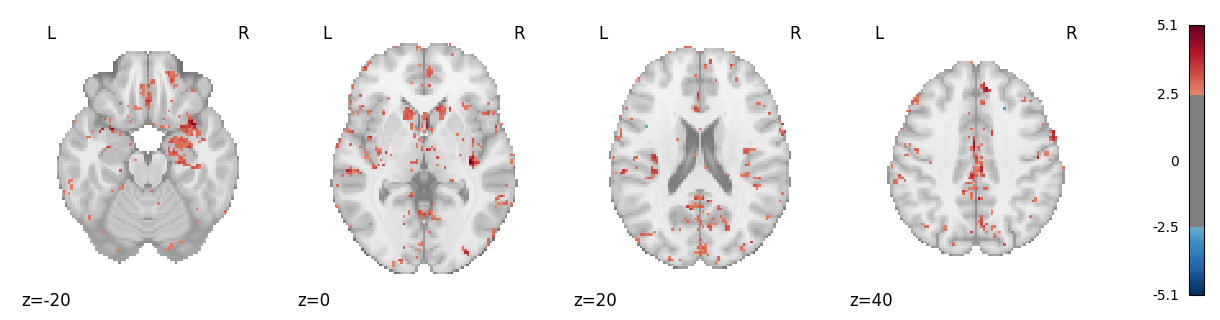

In [27]:
# Visualization code (provided for you - run this after completing the analysis)
fig = plt.figure(figsize=(12, 4))
display = plot_stat_map(
    z_map_sex,
    threshold=2.5,
    display_mode="ortho",
    cut_coords=(0, -20, 10),
    figure=fig,
    title="Sex differences in gray matter density\n(Red: M > F, Blue: F > M)",
)
show()

# Axial slices at different levels
fig2 = plt.figure(figsize=(12, 3))
display2 = plot_stat_map(
    z_map_sex,
    threshold=2.5,
    display_mode="z",
    cut_coords=[-20, 0, 20, 40],
    figure=fig2,
)
show()

### Discussion Questions

Answer the following questions based on your analysis:

- How many males and females were in your sample? Is the sample balanced?

20 males and 30 females. I think it is pretty balanced, but would be best to have 50:50 and a larger sample.

- Which brain regions (if any) show significant differences between males and females? Are there regions where males have more gray matter? Where females have more?

The visual display shows a scattered pattern. I am guessing a lot of it is noise. However some areas may be showing signal. For example in the left anteriori temporal area. There also seems to be a bit of a difference in th einsula area. Males seems to have a greater grey mater density in these areas. Most of the signal in the MRI is red, indicating higher grey matter density in males as compared to females.

- How do the sex difference results compare to the age effect we found earlier? Are the patterns similar or different?

For age, results seem to be more localized and for one colour. Here, there is mostly red, and signal is scattered a bit.

- What are some limitations of this analysis that might affect how we interpret the results?

Sample size was small. Imbalance between groups. not wure what exactly in the analysis.

### Bonus Challenge (Optional)

**For those who finish early**: Try adding age as a covariate in your design matrix (i.e., a third column). This would allow you to test for sex differences while controlling for age effects.

Hint: You'll need to:
1. Extract age from `oasis_dataset_large.ext_vars["age"]`
2. Add it as a column in your design matrix
3. Update the contrast to have 3 values instead of 2

In [28]:
# Step 1: Extract age
age = oasis_dataset_large.ext_vars["age"].values.astype(float)

# Step 2: Build design matrix with age as covariate
design_matrix_sex_age = pd.DataFrame(
    {"sex": sex_coded, "age": age, "intercept": intercept}
)

# Step 3: Fit the model
second_level_model_sex_age = SecondLevelModel(
    smoothing_fwhm=2.0,
    n_jobs=1,
    mask_img=mask_img,
    minimize_memory=True,
    verbose=1,
)

second_level_model_sex_age.fit(
    gray_matter_maps,
    design_matrix=design_matrix_sex_age,
)

# Step 4: Contrast — test sex effect only, ignore age and intercept
z_map_sex_age = second_level_model_sex_age.compute_contrast(
    second_level_contrast=[1, 0, 0],
    output_type="z_score",
)

[SecondLevelModel.fit] Fitting second level model. Take a deep breath.

[SecondLevelModel.fit] Loading mask from <nibabel.nifti1.Nifti1Image object at 0x7c6ba94f67e0>

[SecondLevelModel.fit] Loading data from <nibabel.nifti1.Nifti1Image object at 0x7c6ba7c70140>

/tmp/ipython-input-278/2881336625.py:18: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  second_level_model_sex_age.fit(


[SecondLevelModel.fit] Resampling mask

[SecondLevelModel.fit] Finished fit

[SecondLevelModel.fit] 
Computation of second level model done in 0.97 seconds.

[SecondLevelModel.compute_contrast] Loading data from <nibabel.nifti1.Nifti1Image object at 0x7c6ba95fcfb0>

[SecondLevelModel.compute_contrast] Smoothing images

[SecondLevelModel.compute_contrast] Extracting region signals

[SecondLevelModel.compute_contrast] Cleaning extracted signals

[SecondLevelModel.compute_contrast] Computing image from signals

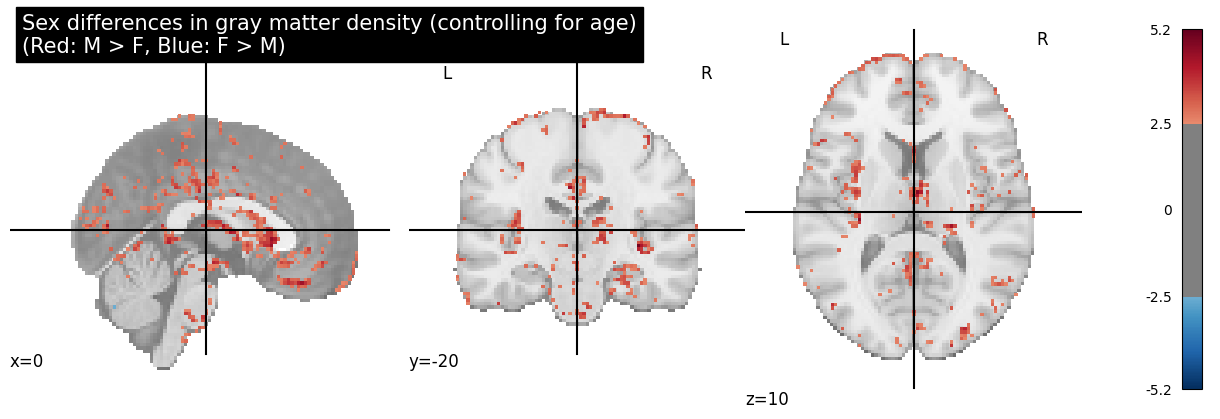

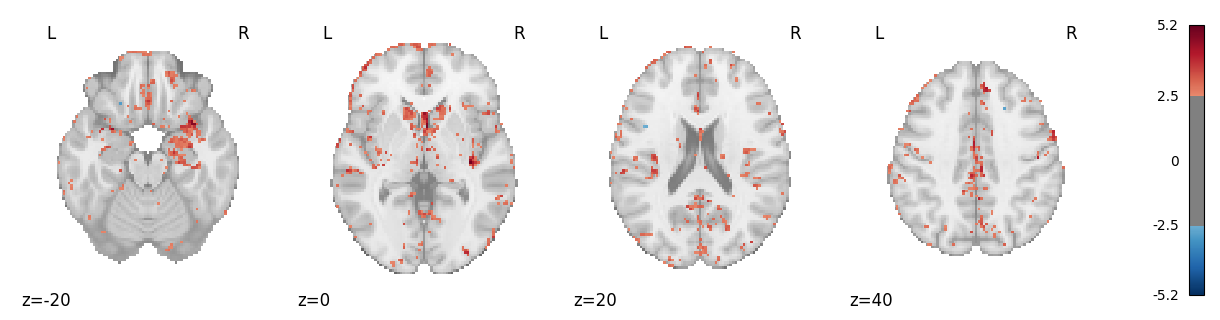

In [29]:
# Orthographic view
fig = plt.figure(figsize=(12, 4))
display = plot_stat_map(
    z_map_sex_age,
    threshold=2.5,
    display_mode="ortho",
    cut_coords=(0, -20, 10),
    figure=fig,
    title="Sex differences in gray matter density (controlling for age)\n(Red: M > F, Blue: F > M)",
)
show()

# Axial slices at different levels
fig2 = plt.figure(figsize=(12, 3))
display2 = plot_stat_map(
    z_map_sex_age,
    threshold=2.5,
    display_mode="z",
    cut_coords=[-20, 0, 20, 40],
    figure=fig2,
)
show()